In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("chess_blitz_change_DanielNaroditsky.csv")

In [3]:
dataset.head()
print(type(dataset))

<class 'pandas.core.frame.DataFrame'>


In [4]:
params = {'converters': {'value': float},'parse_dates': {'time': "%Y-%m-%d %H:%M:%S"}}

dataset = dict()
from river import stream


In [5]:
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import feature_extraction
from river import stats
from river import optim
from river import facto
from river import model_selection
from river import time_series
from river import tree
from river import dummy

In [6]:
import math
import datetime
import numpy as np

hour_list = [str(i) for i in range (0,24)]
minute_list = [f'{str(i)} min' for i in range (0, 60)]
def get_hour(x):
    x['h'] = x['time'].hour
    return x


def get_minute(x):
    x['m'] = x['time'].minute//15 + 1
    return x

def get_day(x):
    
    return {'d' : x['time'].day}

def get_hour_sin_and_cos(x):
    return {'sin_h' : np.sin(np.pi*(x['time'].hour)/12), 'cos_h': np.cos(np.pi*(x['time'].hour)/12)}


def get_minute_distances(x):
    x['sin_m'] = np.sin(np.pi*(x['time'].minute)/30)
    x['cos_m'] = np.cos(np.pi*(x['time'].minute)/30)
    return {'sin_m' : np.sin(np.pi*(x['time'].minute)/30), 'cos_m': np.cos(np.pi*(x['time'].minute)/30)}

def get_date_progress(x):
    return {'date': x['time'].toordinal() - datetime.datetime(2022, 1, 1, 0, 0).toordinal()}

i = 0
temp = [323,323,323,323]
cache = [temp]
my_dict = {}

for x, y in stream.iter_csv('chess_blitz_change_DanielNaroditsky.csv', target = 'value', **params):
    
    if i < 4:
        t = temp.copy()
        t[i] = y
        cache.append(t)      
        temp = t
        my_dict[x['time']] = t
    else:
        t = temp.copy()
        t.pop(0)
        t.append(y)
        cache.append(t)
        temp = t
        my_dict[x['time']] = t
    i += 1



def get_lag(x):
    lag_values = my_dict[x['time']]
    return {'lag_1': lag_values[0], 'lag_2': lag_values[1], 'lag_3': lag_values[2], 'lag_4': lag_values[3]}
    

In [7]:

models = [linear_model.LinearRegression(optimizer=optim.SGD(lr=lr)) for lr in [0.05, 0.02, 0.01, 0.005, 0.002, 0.0001]]


model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_progress', compose.FuncTransformer(get_date_progress)),
        ('lags', compose.FuncTransformer(get_lag))
    )))

model += (
    get_hour | 
        feature_extraction.TargetAgg(
            by=['h'], how=stats.Mean()


))
model += (
    get_minute | 
        feature_extraction.TargetAgg(
            by=['m'], how=stats.Mean()


))

model |=  preprocessing.StandardScaler()
model |= linear_model.LinearRegression(intercept_lr=.1)


# model |=  model_selection.EpsilonGreedyRegressor(models, epsilon=0.025, decay=0.1, burn_in=100, seed=1)
# model |= tree.HoeffdingAdaptiveTreeRegressor(grace_period=100, leaf_prediction='adaptive', model_selector_decay=0.9, seed=0)
# model = preprocessing.TargetStandardScaler(regressor=model)



In [8]:
metric = metrics.MAE() + metrics.R2()
evaluate.progressive_val_score(stream.iter_csv('chess_blitz_change_DanielNaroditsky.csv', target = 'value', **params), model, metric, print_every=50)
# evaluate.progressive_val_score(stream.iter_csv('hospital_wait.csv', target = 'value', **params), dummy.StatisticRegressor(stats.Shift(1)), metric, print_every=50)
model.transform_one(x)

[50] MAE: 4.089929, R2: -0.170547
[100] MAE: 4.178674, R2: -0.134684
[150] MAE: 5.058473, R2: -0.091218
[200] MAE: 4.885818, R2: -0.107654
[250] MAE: 5.206778, R2: -0.134331
[300] MAE: 5.00315, R2: -0.088549
[350] MAE: 4.844644, R2: -0.037667
[400] MAE: 4.623499, R2: -0.020982
[450] MAE: 4.568198, R2: 0.01713
[500] MAE: 4.57813, R2: 0.050901
[550] MAE: 4.527234, R2: 0.075348
[600] MAE: 4.394253, R2: 0.116857
[650] MAE: 4.295594, R2: 0.165761
[700] MAE: 4.195799, R2: 0.203754
[750] MAE: 4.120062, R2: 0.269578
[800] MAE: 4.009955, R2: 0.303529
[850] MAE: 3.880479, R2: 0.339306
[900] MAE: 3.752731, R2: 0.371038
[950] MAE: 3.61703, R2: 0.392701
[1,000] MAE: 3.504704, R2: 0.436547


{'y_mean_by_m': -0.38837284379450204,
 'y_mean_by_h': 0.16287976262493573,
 'lag_1': -1.6250997255227144,
 'lag_2': 0.055654822898429934,
 'lag_3': -1.313662374094955,
 'lag_4': 1.1181825650232176,
 'date': 1.379219495446056}

MAE: 1,480.203005	(rolling 10) MAE: 13.5	(rolling 10)


C:\Users\This PC\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\This PC\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


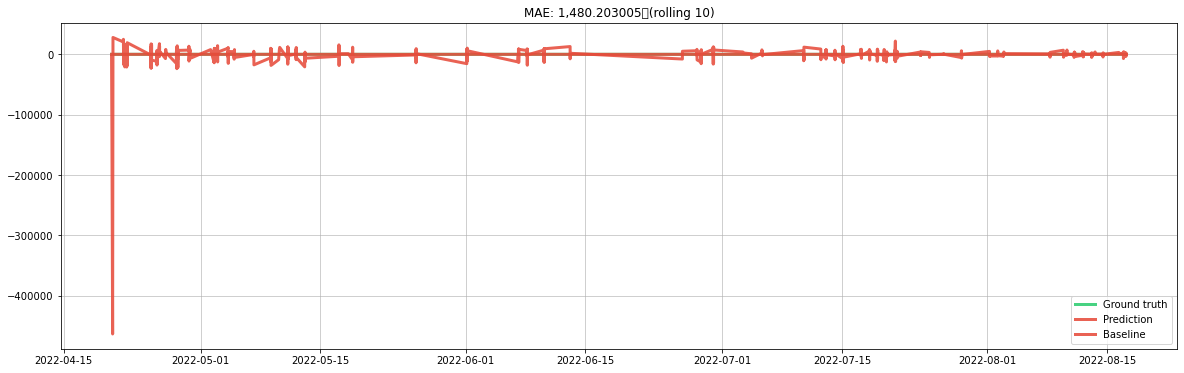

In [9]:
from river import metrics
import matplotlib.pyplot as plt
import collections


queue = collections.deque([], 4)

def evaluate_model(model): 

    metric = metrics.Rolling(metrics.MAE(), 10)
    metric_b = metrics.Rolling(metrics.MAE(), 10)
    
    dates = []
    y_trues = []
    y_preds = []
    
    baseline = 0
    y_baseline = []
    for x, y in stream.iter_csv('chess_blitz_change_DanielNaroditsky.csv', target = 'value', **params):
        
        new_feats = {f"lag_{i}": v for i, v in enumerate(queue)}

        # copy of x
        x_ = dict(x)
        x_.update(new_feats)

        y_pred = model.predict_one(x_)
        model.learn_one(x_, y)

        queue.append(y)

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)
        metric_b.update(y, baseline)
        
        # Store the true value and the prediction
        dates.append(x['time'])
        y_trues.append(y)
        y_preds.append(y_pred)
        y_baseline.append(baseline)
        baseline = y
        
    print(metric, metric_b)

    # Plot the results
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=800, label='Ground truth')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=800, label='Prediction')
    ax.plot(dates, y_baseline, lw=3, color='#e74c3c', alpha=800, label='Baseline')
    ax.legend()
    ax.set_title(metric)
evaluate_model(model)


In [10]:
def make_model(alpha):
    models = [linear_model.LinearRegression(optimizer=optim.SGD(lr=lr), loss=optim.losses.Quantile(alpha=alpha)) for lr in [0.05, 0.02, 0.01, 0.005, 0.002, 0.0001]]


    model = compose.Pipeline(
        ('features', compose.TransformerUnion(
            ('date_progress', compose.FuncTransformer(get_date_progress)),
            ('lags', compose.FuncTransformer(get_lag))
        )))

    model += (
        get_hour | 
            feature_extraction.TargetAgg(
                by=['h'], how=stats.Mean()


    ))
    # model += (
    #     get_minute | 
    #         feature_extraction.TargetAgg(
    #             by=['m'], how=stats.Mean()


    # ))

    model |=  preprocessing.StandardScaler()
    model |= preprocessing.TargetStandardScaler( 
        model_selection.UCBRegressor(
            models,
            delta=0.01, burn_in=100, seed=1
        )
    )
    return model


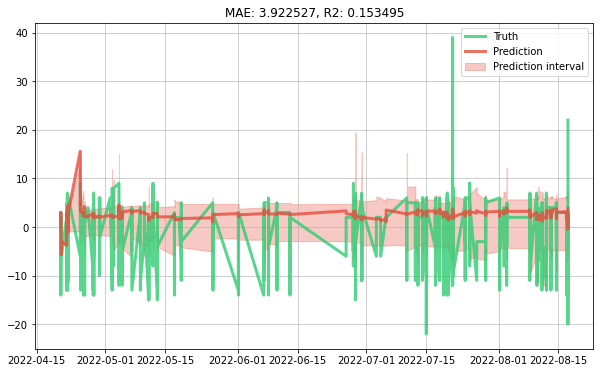

In [11]:
models = {
    'lower': make_model(alpha=0.05),
    'center': make_model(alpha=0.5),
    'upper': make_model(alpha=0.95)
}

dates = []
y_trues = []
y_preds = {
    'lower': [],
    'center': [],
    'upper': []
}

for x, y in stream.iter_csv('chess_blitz_change_DanielNaroditsky.csv', target = 'value', **params):
    y_trues.append(y)
    dates.append(x['time'])

    for name, model in models.items():
        y_preds[name].append(model.predict_one(x))
        model.learn_one(x, y)

    # Update the error metric
    metric.update(y, y_preds['center'][-1])

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Truth')
ax.plot(dates, y_preds['center'], lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.fill_between(dates, y_preds['lower'], y_preds['upper'], color='#e74c3c', alpha=0.3, label='Prediction interval')
ax.legend()
ax.set_title(metric);